# Logistic Regression (Juices dataset)

In [18]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


## Import local utility functions and classes

In [19]:
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Model configuration

In [20]:
# model mode (training'or 'predict')
model_mode      = 'predict'

# data filenames
data_filename   = '../../data/juices/FTIR_juices.csv'
sample_filename = '../generative_models/ppc_samples_juices.csv'
trace_filename  = './traces/trace_juices'
ppc_filename    = './ppc_samples_juices_predicted.csv'

## Load dataset, import and plot samples

In [21]:
# init dataset object
data_obj = Data(data_filename, 'label', -1)

if model_mode == 'training':    
    data_obj.data.head(5)
else:
    sample_obj = Data(sample_filename, 'label', -1)

NON-Strawberry: blue
Strawberry: red


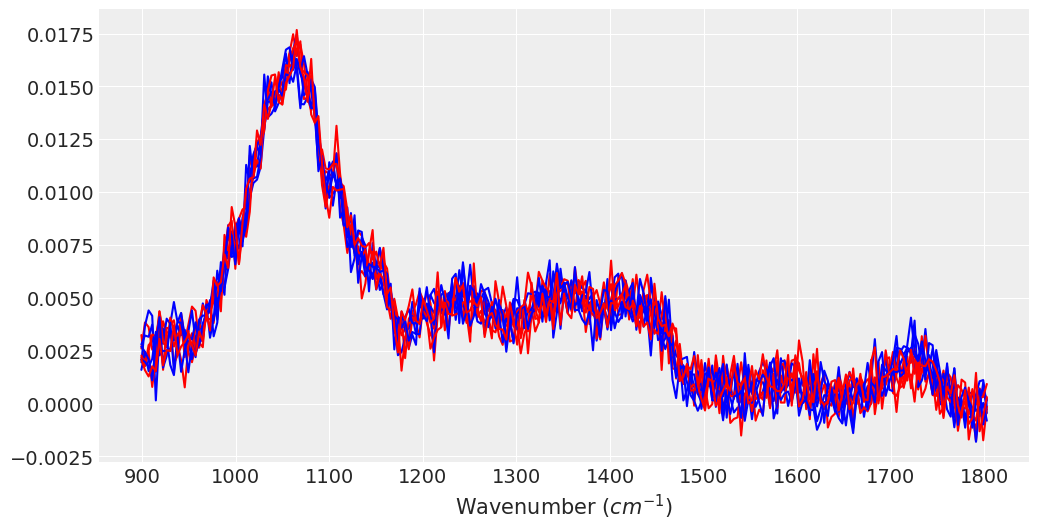

In [22]:
# plot dataframe
if model_mode == 'training':
    utl.plot_data(data_obj, 50)
else:
    utl.plot_data(sample_obj, 10)

In [35]:
# number of samples from each class
if model_mode == 'training':
    print(data_obj.data[data_obj.label_column].value_counts())
else:
    print(sample_obj.data[sample_obj.label_column].value_counts())

NON-Strawberry    100
Strawberry        100
Name: label, dtype: int64


In [24]:
# generate training and test sets
train_data, test_data = train_test_split(data_obj.data, test_size=0.33, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [25]:
test_data.shape

(325, 236)

In [26]:
train_data.shape

(658, 236)

# Model definition (Multiple Logistic Regression)
The following statistical model is assumed:

\begin{equation}
\alpha \sim \mathcal{N}(\mu_{\alpha},\,\sigma^{2}_{\alpha}) \\
\beta \sim \mathcal{N}(\mu_{\beta},\,\sigma^{2}_{\beta}) \\
\theta = logistic(\alpha+\beta X) \\
y \sim Bernoulli(\theta)
\end{equation}

In [27]:
# get Y labels and standardize the data
Y = pd.Categorical(train_data[data_obj.label_column]).codes
x_n = train_data.columns[:data_obj.non_data_columns]
x_s = train_data[x_n].values
x_s = utl.standardize(x_s)

In [28]:
with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_s, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
     
    y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 

    if model_mode == 'training':
        trace_mlr = pm.sample(2000, init='adapt_diag', random_seed=42)
    else:
        # load traces from trained model
        trace_mlr = pm.backends.text.load(trace_filename)

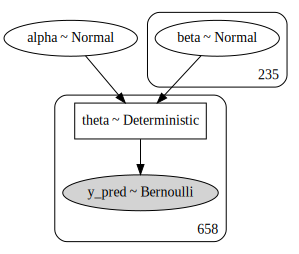

In [29]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [30]:
if model_mode == 'training':
    varnames = ['alpha', 'beta']
    coef = az.summary(trace_mlr, varnames)
    print(coef)

In [31]:
if model_mode == 'training':
    az.plot_energy(trace_mlr, figsize=(10, 6));

# Model predictions

In [32]:
if model_mode == 'training':
    # check model predictions on test dataset
    test_data = utl.display_predictions(data_obj, trace_mlr, test_data)
else:
    # check model predictions on sample data
    utl.display_predictions_ppc(sample_obj, trace_mlr)

              label         p_label
95       Strawberry  NON-Strawberry
15       Strawberry      Strawberry
30   NON-Strawberry      Strawberry
158  NON-Strawberry  NON-Strawberry
128  NON-Strawberry      Strawberry
..              ...             ...
106  NON-Strawberry  NON-Strawberry
14   NON-Strawberry  NON-Strawberry
92   NON-Strawberry  NON-Strawberry
179      Strawberry  NON-Strawberry
102  NON-Strawberry  NON-Strawberry

[200 rows x 2 columns]


In [33]:
if model_mode == 'training':
    # prediction score on test dataset
    utl.logistic_score(data_obj, test_data, 'p_label')
else:
    # prediction score on sample data
    utl.logistic_score_ppc(sample_obj, 'p_label')

total  : 200
correct: 90
error  : 110
score  : 45.0%


## Save results

In [34]:
if model_mode == 'training':
    # save inference results
    pm.backends.text.dump(trace_filename, trace_mlr)
else:
    # save prediction results
    sample_obj.data.to_csv(ppc_filename)